<a href="https://colab.research.google.com/github/LuciaHrovatin/Credit_Analytics/blob/main/CreditAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Credit Analytics
## Project 1
### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

</center>

In [1]:
# Import all the Python libraries we are going to use

# Data Transformation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical learning
from scipy.stats import bernoulli
from sklearn import preprocessing # data normalization
from sklearn import metrics # evaluation metric
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # evaluation metric
from sklearn.metrics import roc_curve # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric
from sklearn.metrics import classification_report # evaluation metric
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model

# Deep Learning
try:
    import keras
except ImportError:
    !pip install keras --quiet
    import keras

try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner as kt

In [2]:
### Fix random seed for reproducibility
random_seed = 1024
np.random.seed(random_seed)

# Exercise 1. Dataset features generation.

In [3]:
# Number of samples
m = 20000  # training set
n = 10000  # test set

# Total number of samples
total_samples = m + n

# Generate xi1: age from the uniform distribution on [18, 80]
x1 = np.random.uniform(18, 80, total_samples)

# Generate xi2: monthly income (in CHF 1000) from the uniform distribution on [1, 15]
x2 = np.random.uniform(1, 15, total_samples)

# Generate xi3: salaried/self-employed in {0, 1}, where 0=salaried and 1=self-employed (probability of being self-employed is 10%)
x3 = np.random.choice([0, 1], total_samples, p=[0.9, 0.1])

# Exercise 2. Dataset labels generation.

In [4]:
# Define logistic function
sigmoid = lambda z: 1 / (1 + np.exp(-z))

# Probability functions
p1 = sigmoid(-13.3 + 0.33*x1 - 3.5*x2 + 3*x3)

p2 = sigmoid(-5 + 10*((x1<25) | (x1>75)) - 1.1*x2 + x3)

# Generate labels
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

# Create dataframes for the labels
df1 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y1})
df2 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y2})

In [5]:
# Divide the dataset into training and test sets
training_set_x, test_set_x = np.stack([x1, x2, x3], axis=1)[:m], np.stack([x1, x2, x3], axis=1)[m:]
training_set_y1, test_set_y1 = y1[:m], y1[m:]
training_set_y2, test_set_y2 = y2[:m], y2[m:]

# Features normalization
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
training_set_x = scaler.fit_transform(training_set_x)
test_set_x = scaler.transform(test_set_x)

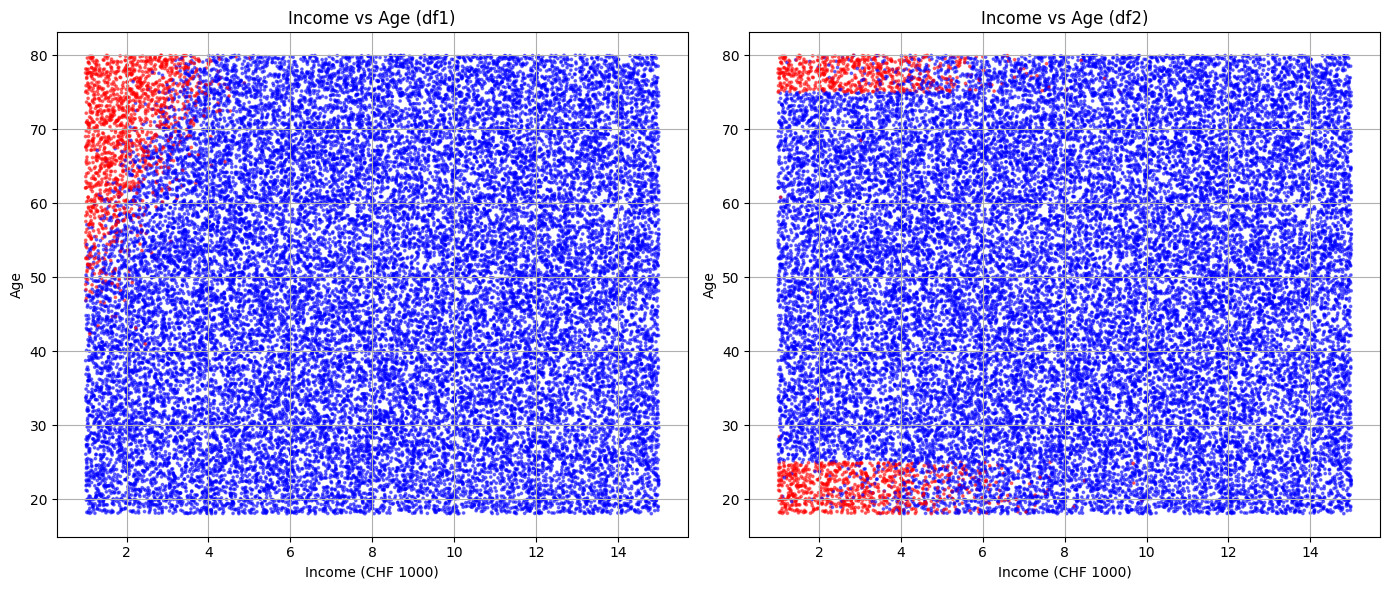

In [6]:
# Exploratory plots

plt.figure(figsize=(14, 6))

# Scatter plot for df1
plt.subplot(1, 2, 1)
colors = {0: 'blue', 1: 'red'}
plt.scatter(df1['Income'], df1['Age'], c=df1['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df1)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for df2
plt.subplot(1, 2, 2)
plt.scatter(df2['Income'], df2['Age'], c=df2['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df2)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

# Exercise 3. Model implementations.

### 3a) Logistic regression (LR)

In [7]:
# Implement and train a logistic regression model
np.random.seed(random_seed)
logistic_regression_linear = LogisticRegression(penalty=None, random_state=random_seed).fit(training_set_x, training_set_y1)
logistic_regression_nonlinear = LogisticRegression(penalty=None, random_state=random_seed).fit(training_set_x, training_set_y2)

# Look at the parameters of the fitted model
print('Coefficients1:', logistic_regression_linear.coef_)
print('Intercept1:', logistic_regression_linear.intercept_)
print('Coefficients2:', logistic_regression_nonlinear.coef_)
print('Intercept2:', logistic_regression_nonlinear.intercept_)
# Predict the labels for the test set
predicted_y1 = logistic_regression_linear.predict(test_set_x)
predicted_y2 = logistic_regression_nonlinear.predict(test_set_x)

Coefficients1: [[ 19.88735085 -46.63023023   2.98435454]]
Intercept1: [-10.69877257]
Coefficients2: [[-0.91398839 -7.22383489  0.34305162]]
Intercept2: [-0.42218355]


In [8]:
from sklearn.metrics import accuracy_score

def LR_tester(train_x, train_y, test_x, test_y, y_pred):
  # Define models
  models = {
    'No Penalty': LogisticRegression(penalty=None),
    'Ridge (L2)': LogisticRegression(penalty='l2', C=0.1, max_iter=10000),
  }
  for name, model in models.items():
      model.fit(train_x, train_y)
      y_pred = model.predict(test_x)
      acc = accuracy_score(test_y, y_pred)
      print(f"{name} Accuracy: {acc:.3f}")

# linear case
LR_tester(training_set_x, training_set_y1, test_set_x, test_set_y1, predicted_y1)

# non linear case
LR_tester(training_set_x, training_set_y2, test_set_x, test_set_y2, predicted_y2)

No Penalty Accuracy: 0.985
Ridge (L2) Accuracy: 0.967
No Penalty Accuracy: 0.954
Ridge (L2) Accuracy: 0.954


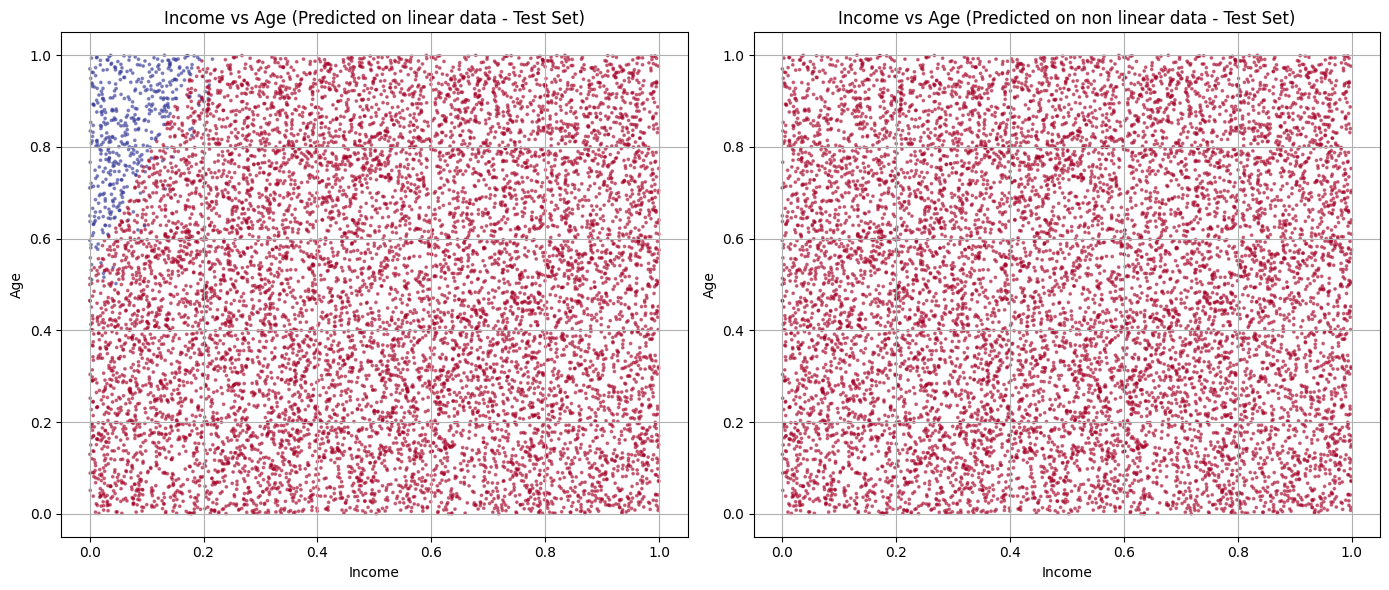

In [9]:
# Exploratory Plots

plt.figure(figsize=(14, 6))

# Scatter plot for predicted_y1
plt.subplot(1, 2, 1)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y1, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for predicted_y2( really bad!)
plt.subplot(1, 2, 2)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y2, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on non linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Compute cross-entropy loss for the training set
train_loss_y1 = log_loss(training_set_y1, logistic_regression_linear.predict_proba(training_set_x))
train_loss_y2 = log_loss(training_set_y2, logistic_regression_nonlinear.predict_proba(training_set_x))

# Compute cross-entropy loss for the test set
test_loss_y1 = log_loss(test_set_y1, logistic_regression_linear.predict_proba(test_set_x))
test_loss_y2 = log_loss(test_set_y2, logistic_regression_nonlinear.predict_proba(test_set_x))

print(f'Training Loss for y1: {train_loss_y1:.3f}')
print(f'Training Loss for y2: {train_loss_y2:.3f}')
print(f'Test Loss for y1: {test_loss_y1:.3f}')
print(f'Test Loss for y2: {test_loss_y2:.3f}')

Training Loss for y1: 0.033
Training Loss for y2: 0.149
Test Loss for y1: 0.033
Test Loss for y2: 0.142


### 3b) Neural network (NN)

#### Simple FNN

In [11]:
# Implement and train a neural network model
# Starting Parameters
lr = 0.01 # learning rate
batch_size = 1024
epochs = 100

def NeuralNetwork(units, lr, hl_number, loss_function=keras.losses.BinaryCrossentropy()):
  """
  This function creates a neural network, depending on the given parameters:
  - units: number of neurons in the hidden layers
  - lr: learning rate
  - hl_number: number of hidden layers
  - Adds batch normalization after each dense hidden layer.
  """

  model = keras.Sequential()
  model.add(keras.Input(shape=(3,)))

  for i in range(hl_number):
    model.add(keras.layers.Dense(units,
                               activation='relu'))  # Features initialization)

  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=loss_function)
  return model

neural_network_linear = NeuralNetwork(20, lr, 2)
neural_network_nonlinear = NeuralNetwork(50, lr, 2)

neural_network_linear.summary()
neural_network_nonlinear.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the linear model
tf.keras.utils.set_random_seed(random_seed)
np.random.seed(random_seed)
history1_linear = neural_network_linear.fit(x=training_set_x, y=training_set_y1, batch_size=batch_size, epochs=epochs, validation_split=0.2,verbose = 0)

In [13]:
# Train the non linear model
tf.keras.utils.set_random_seed(random_seed)
np.random.seed(random_seed)
history2_nonlinear = neural_network_nonlinear.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)

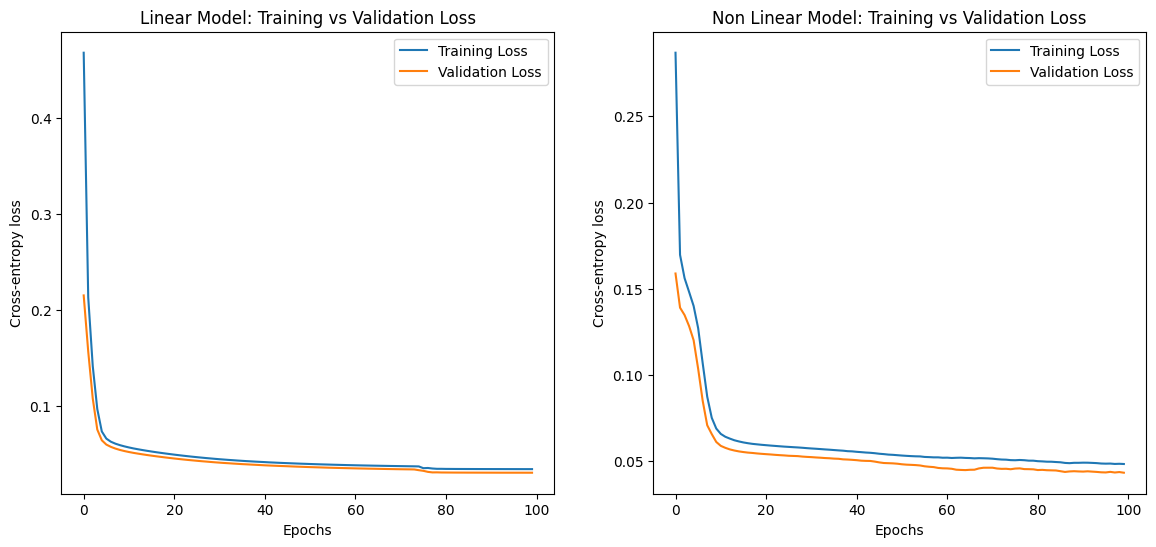

In [14]:
def plot_performance(title, history):
  plt.title(f'{title}: Training vs Validation Loss')
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.ylabel('Cross-entropy loss')
  plt.xlabel('Epochs')
  plt.legend()

# Training Performance
plt.figure(figsize=(14, 6))


# Plot cross-entropy for linear data
plt.subplot(1, 2, 1)
plot_performance('Linear Model', history1_linear)

# Plot cross-entropy for non-linear data
plt.subplot(1, 2, 2)
plot_performance('Non Linear Model', history2_nonlinear)

plt.show()

In [15]:
# Compute cross-entropy loss for the training set
train_loss_nn1_linear = neural_network_linear.evaluate(training_set_x, training_set_y1, verbose=1)
train_loss_nn2_nonlinear = neural_network_nonlinear.evaluate(training_set_x, training_set_y2, verbose=1)

# Compute cross-entropy loss for the test set
test_loss_nn1_linear = neural_network_linear.evaluate(test_set_x, test_set_y1, verbose=1)
test_loss_nn2_nonlinear = neural_network_nonlinear.evaluate(test_set_x, test_set_y2, verbose=1)

predicted_nn_y1 = neural_network_linear.predict(test_set_x)
predicted_nn_y2 = neural_network_nonlinear.predict(test_set_x)

print(f"Training Loss for neural network 1 linear: {train_loss_nn1_linear:.3f}")
print(f"Test Loss for neural network 1 linear: {test_loss_nn1_linear:.3f}")

print(f"Training Loss for neural network 2 non linear: {train_loss_nn2_nonlinear:.3f}")
print(f"Test Loss for neural network 2 non linear: {test_loss_nn2_nonlinear:.3f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0333
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0459
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0318
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0469
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training Loss for neural network 1 linear: 0.033
Test Loss for neural network 1 linear: 0.034
Training Loss for neural network 2 non linear: 0.047
Test Loss for neural network 2 non linear: 0.045


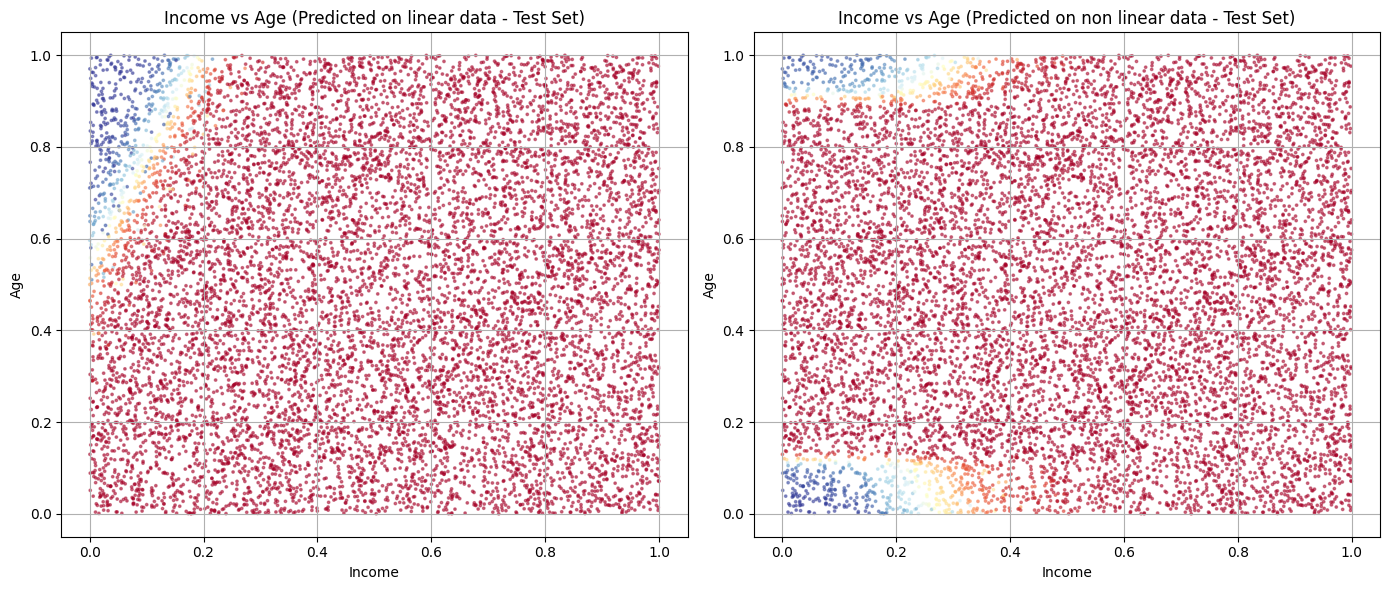

In [16]:
plt.figure(figsize=(14, 6))

# Scatter plot for predicted_y1
plt.subplot(1, 2, 1)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_nn_y1, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for predicted_y2( really bad!)
plt.subplot(1, 2, 2)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_nn_y2, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on non linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Hyperparameter Tuning with normal loss function

In [17]:
e = 300
class HyperModelTuned(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(3,)))

        # Activation function
        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu'])

        # Tune the number of layers
        for i in range(hp.Int('num_layers', 2, 5)): #number of layers
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=32, max_value=64, step=2),
                activation=None, #activation function set to none to perform batch normalization
                bias_initializer='zeros',
                kernel_initializer="he_normal")) # Weight initialization along with ReLU
            model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer

            # Activation function
            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU(negative_slope=0.2))

        model.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

        hp_learning_rate = hp.Choice('learning_rate',
                                    values=[1e-2, 1e-3, 1e-4]
                                    )
        optimizers_dict = {
            "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
            "RMSprop":     keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
            }


        hp_optimizers = hp.Choice(
            'optimizer',
            values=["Adam", "RMSprop"]
            )

        model.compile(
            loss=keras.losses.BinaryCrossentropy(),
            optimizer=optimizers_dict[hp_optimizers],
            metrics=['recall', 'accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

def tuner_build_model_cv(training_set_x, training_set_y, path, name, e, random_seed, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    all_val_losses = []

    # Save the best tuner from all folds
    best_tuner = None
    best_loss = float('inf')

    fold = 1
    for train_index, val_index in kfold.split(training_set_x):
        print(f"\n--- Fold {fold} ---")

        x_train, x_val = training_set_x[train_index], training_set_x[val_index]
        y_train, y_val = training_set_y[train_index], training_set_y[val_index]

        tuner = kt.RandomSearch(
            HyperModelTuned(),
            objective='val_loss',
            max_trials=10,
            executions_per_trial=1,
            seed=random_seed,
            directory=path,
            project_name=f"{name}_fold{fold}"
        )

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tuner.search(x_train, y_train, epochs=e, validation_data=(x_val, y_val), callbacks=[stop_early])

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hp)
        best_model.fit(x_train, y_train, epochs=e, validation_split=0.2, callbacks=[stop_early])

        val_loss = best_model.evaluate(x_val, y_val, verbose=0)[0]
        all_val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_tuner = tuner

        fold += 1

    print(f"\nAverage validation loss over {k} folds: {np.mean(all_val_losses)}")
    return best_tuner

# Get the optimal hyperparameters
tuner_nonlinear_noLossCustomization = tuner_build_model_cv(training_set_x, training_set_y2, 'tuner', 'modeling_tuned', random_seed=random_seed, e=e)

Trial 10 Complete [00h 01m 17s]
val_loss: 0.05438246577978134

Best val_loss So Far: 0.05370234698057175
Total elapsed time: 00h 11m 59s
Epoch 1/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9353 - loss: 0.2039 - recall: 0.3545 - val_accuracy: 0.9756 - val_loss: 0.0687 - val_recall: 0.5328
Epoch 2/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9562 - loss: 0.1001 - recall: 0.4675 - val_accuracy: 0.9697 - val_loss: 0.0749 - val_recall: 0.7049
Epoch 3/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9579 - loss: 0.0919 - recall: 0.5021 - val_accuracy: 0.9766 - val_loss: 0.0628 - val_recall: 0.6967
Epoch 4/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9600 - loss: 0.0884 - recall: 0.5400 - val_accuracy: 0.9762 - val_loss: 0.0595 - val_recall: 0.6639
Epoch 5/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9596 - loss: 0.0860 - recall: 0.5415 - val_accuracy: 0.9753 - val_loss: 0.0616 - val_recall: 0.6557
Epoch 6/300
400/400 ━━━━━━━━

In [18]:
best_NN_nonlinear_cv = tuner_nonlinear_noLossCustomization.hypermodel.build(tuner_nonlinear_noLossCustomization.get_best_hyperparameters(num_trials = 1)[0])
history_nonlinear_cv = best_NN_nonlinear_cv.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=e, validation_split=0.2, verbose = 0)

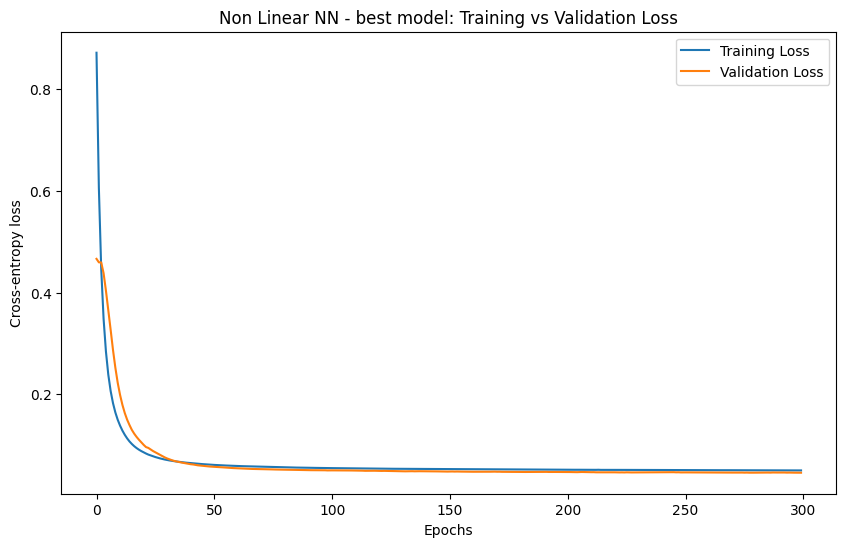

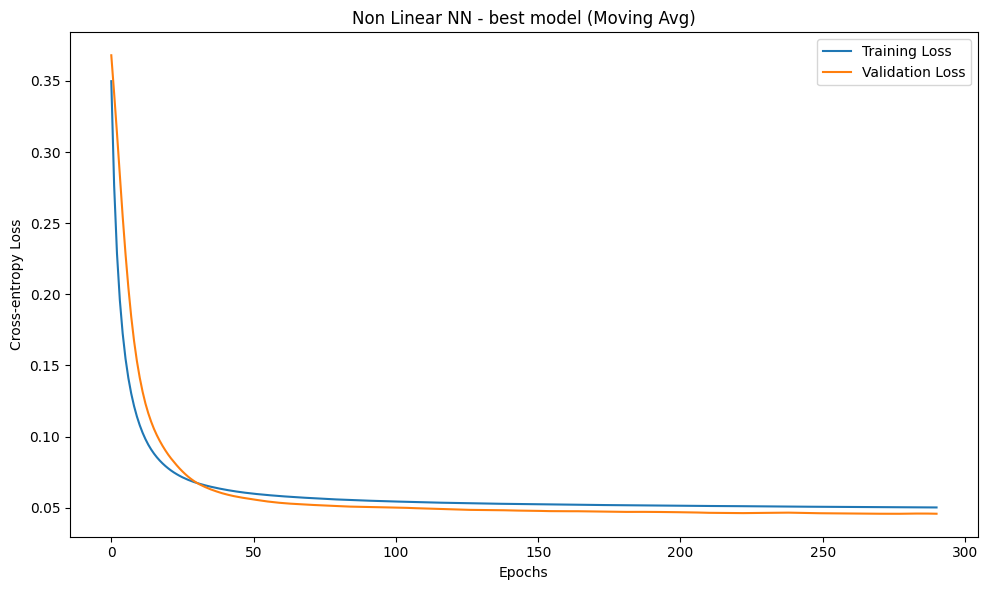

In [19]:
# Plot cross-entropy for best tuner
plt.figure(figsize=(10, 6))
plot_performance('Non Linear NN - best model', history_nonlinear_cv)
plt.show()

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Extract losses
train_loss = history_nonlinear_cv.history['loss']
val_loss = history_nonlinear_cv.history.get('val_loss', [])

# Compute moving averages
window_size = 10
ma_train_loss = moving_average(train_loss, window_size)
ma_val_loss = moving_average(val_loss, window_size) if val_loss else []

# Plot
plt.figure(figsize=(10, 6))
plt.title(f'Non Linear NN - best model (Moving Avg)')
plt.plot(ma_train_loss, label='Training Loss')
if val_loss:
    plt.plot(ma_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Get the best hyperparameters from the tuner
best_hps = tuner_nonlinear_noLossCustomization.get_best_hyperparameters(1)[0]

# Print all the hyperparameters
print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

best_NN_nonlinear_cv.summary()

Best hyperparameters:
activation_type: relu
num_layers: 2
units_layer_0: 54
units_layer_1: 42
learning_rate: 0.001
optimizer: Adam
batch_size: 128
units_layer_2: 58
units_layer_3: 62


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 54)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 54)             │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 42)             │         2,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,477 (33.12 KB)

 Trainable params: 2,761 (10.79 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 5,524 (21.58 KB)

#### Customized Loss Function

In [78]:
# Customize loss function
def binary_cost_sensitive_loss(y_true, y_pred):
    # Avoid log(0) by clipping predicted probabilities
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # For true positives (y==1): weight the negative log likelihood by 100.
    loss_pos = -100 * y_true * tf.math.log(y_pred)

    # For negatives (y==0): use the negative log likelihood; then subtract the profit (1)
    loss_neg = -(1 - y_true) * (tf.math.log(1 - y_pred) + 1)

    # Sum the losses and take the average over the batch.
    loss = loss_pos + loss_neg
    return tf.reduce_mean(loss)

In [79]:
neural_network_customized = NeuralNetwork(50, lr, 2, binary_cost_sensitive_loss)
history_nonlinear = neural_network_customized.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)

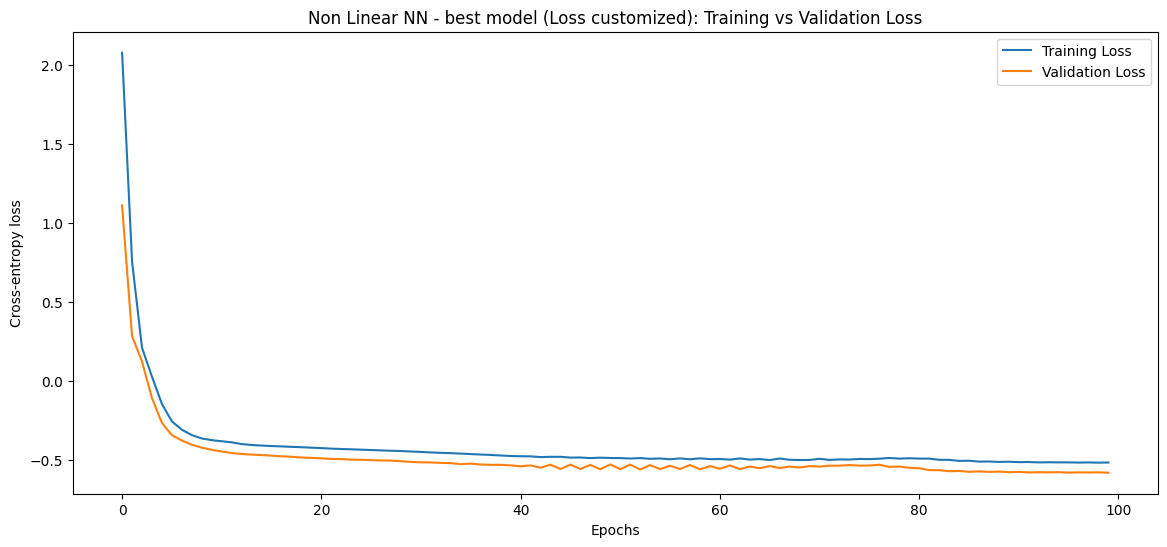

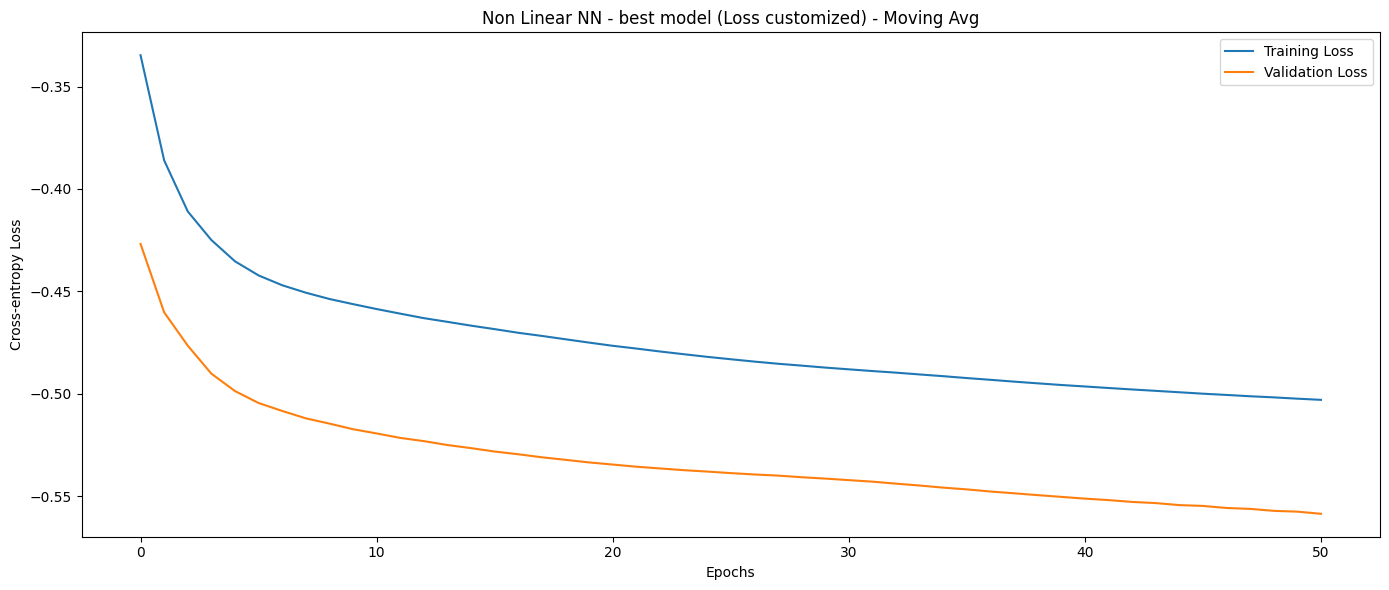

In [80]:
# Plot cross-entropy for linear data
plt.figure(figsize=(14, 6))
plot_performance('Non Linear NN - best model (Loss customized)', history_nonlinear)
plt.show()

# Extract losses
train_loss_customized = history_nonlinear.history['loss']
val_loss_customized = history_nonlinear.history.get('val_loss', [])

# Compute moving averages
window_size = 50
ma_train_loss_customized = moving_average(train_loss_customized, window_size)
ma_val_loss_customized = moving_average(val_loss_customized, window_size) if val_loss else []

# Plot
plt.figure(figsize=(14, 6))
plt.title(f'Non Linear NN - best model (Loss customized) - Moving Avg')
plt.plot(ma_train_loss_customized, label='Training Loss')
if val_loss:
    plt.plot(ma_val_loss_customized, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy Loss')
plt.legend()
plt.tight_layout()
plt.show()


### 3c) ROC curves and AUC scores

In [81]:
# Get predictions for all models
# Linear data models
logistic_linear_test_pred = logistic_regression_linear.predict_proba(test_set_x)[:, 1]
neural_linear_test_pred = neural_network_linear.predict(test_set_x)

# Non-linear data models
logistic_nonlinear_test_pred = logistic_regression_nonlinear.predict_proba(test_set_x)[:, 1]

# Benchmark NN
NN_benchmark = neural_network_nonlinear.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_benchmark), digits=3))

# NN fine-tuned
NN_tuned = best_NN_nonlinear_cv.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_tuned), digits=3))
print(metrics.confusion_matrix(test_set_y2, np.round(NN_tuned)))

# NN with customized Loss
NN_customized = neural_network_customized.predict(test_set_x)
print(classification_report(test_set_y2, np.round(NN_customized), digits=3))
print(metrics.confusion_matrix(test_set_y2, np.round(NN_customized)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0      0.991     0.991     0.991      9539
           1      0.808     0.822     0.815       461

    accuracy                          0.983     10000
   macro avg      0.900     0.906     0.903     10000
weighted avg      0.983     0.983     0.983     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0      0.991     0.992     0.991      9539
           1      0.824     0.805     0.814       461

    accuracy                          0.983     10000
   macro avg      0.908     0.898     0.903     10000
weighted avg      0.983     0.983     0.983     10000

[[9460   79]
 [  90  371]]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0      1.000     0.896     0.945      9539
           1      0.315     0.991     0.479   

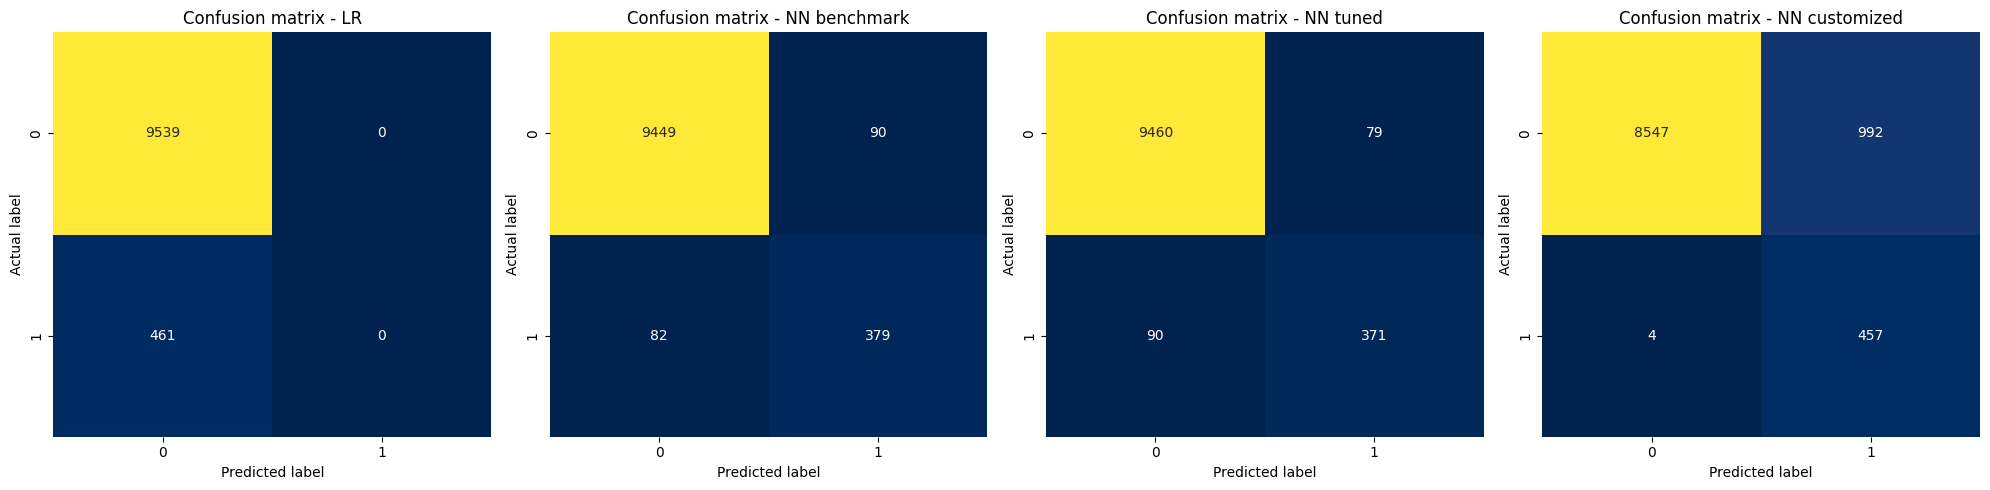

In [82]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
class_names = ["0", "1"]

# Helper function for plotting each confusion matrix
def plot_conf_matrix(ax, cm, title):
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="cividis", fmt='g', cbar=False, ax=ax)
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)

# Confusion matrices
cm1 = metrics.confusion_matrix(test_set_y2, predicted_y2)
cm2 = metrics.confusion_matrix(test_set_y2, np.round(NN_benchmark))
cm3 = metrics.confusion_matrix(test_set_y2, np.round(NN_tuned))
cm4 = metrics.confusion_matrix(test_set_y2, np.round(NN_customized))

# Plot each
plot_conf_matrix(axes[0], cm1, 'Confusion matrix - LR')
plot_conf_matrix(axes[1], cm2, 'Confusion matrix - NN benchmark')
plot_conf_matrix(axes[2], cm3, 'Confusion matrix - NN tuned')
plot_conf_matrix(axes[3], cm4, 'Confusion matrix - NN customized')

plt.tight_layout()
plt.show()

In [83]:
# Compute ROC curves and AUC scores
# Linear data comparison
fpr_logistic_linear, tpr_logistic_linear, _ = roc_curve(test_set_y1, logistic_linear_test_pred)
auc_logistic_linear = roc_auc_score(test_set_y1, logistic_linear_test_pred)

fpr_neural_linear, tpr_neural_linear, _ = roc_curve(test_set_y1, neural_linear_test_pred)
auc_neural_linear = roc_auc_score(test_set_y1, neural_linear_test_pred)

# Non-linear data comparison
fpr_logistic_nonlinear, tpr_logistic_nonlinear, _ = roc_curve(test_set_y2, logistic_nonlinear_test_pred)
auc_logistic_nonlinear = roc_auc_score(test_set_y2, logistic_nonlinear_test_pred)

fpr_NN_benchmark, tpr_NN_benchmark, _ = roc_curve(test_set_y2, NN_benchmark)
auc_NN_benchmark = roc_auc_score(test_set_y2, NN_benchmark)

fpr_NN_tuned, tpr_NN_tuned, _ = roc_curve(test_set_y2, NN_tuned)
auc_NN_tuned = roc_auc_score(test_set_y2, NN_tuned)

fpr_NN_customized, tpr_NN_customized, _ = roc_curve(test_set_y2, NN_customized)
auc_NN_customized = roc_auc_score(test_set_y2, NN_customized)


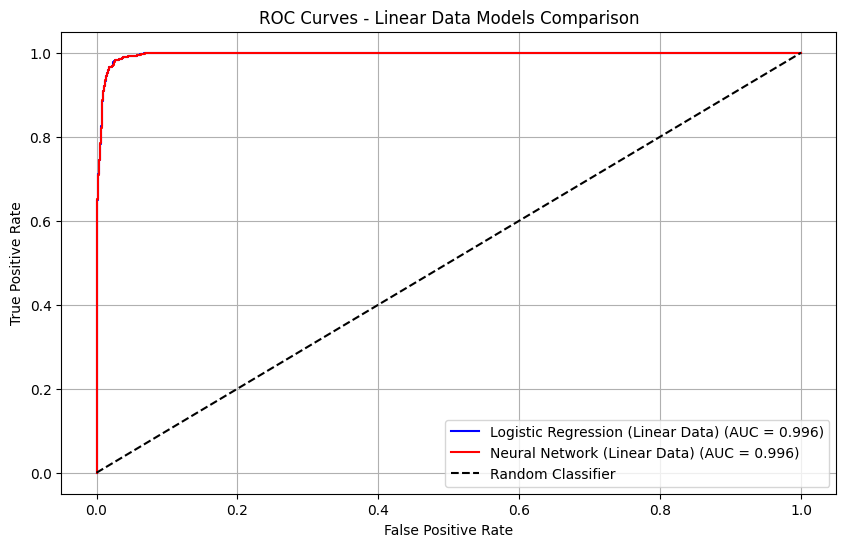

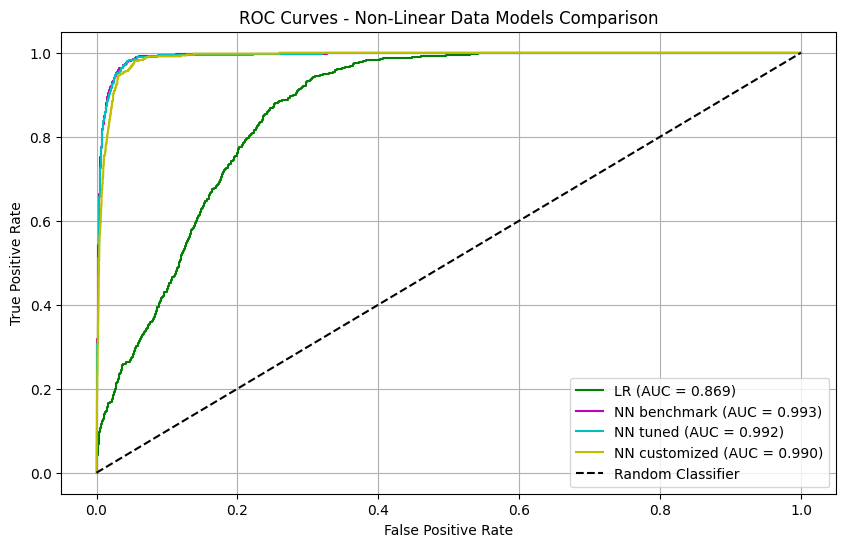

Linear Data Comparison:
Logistic Regression AUC: 0.996
Neural Network AUC: 0.996

Non-Linear Data Comparison:
Logistic Regression AUC: 0.869
Neural Network AUC: 0.993
Neural Network AUC: 0.992
Neural Network AUC: 0.990


In [84]:
# Plot ROC curves for linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_linear, tpr_logistic_linear, 'b-', label=f'Logistic Regression (Linear Data) (AUC = {auc_logistic_linear:.3f})')
plt.plot(fpr_neural_linear, tpr_neural_linear, 'r-', label=f'Neural Network (Linear Data) (AUC = {auc_neural_linear:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot ROC curves for non-linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_nonlinear, tpr_logistic_nonlinear, 'g-', label=f'LR (AUC = {auc_logistic_nonlinear:.3f})')
plt.plot(fpr_NN_benchmark, tpr_NN_benchmark, 'm-', label=f'NN benchmark (AUC = {auc_NN_benchmark:.3f})')
plt.plot(fpr_NN_tuned, tpr_NN_tuned, 'c-', label=f'NN tuned (AUC = {auc_NN_tuned:.3f})')
plt.plot(fpr_NN_customized, tpr_NN_customized, 'y-', label=f'NN customized (AUC = {auc_NN_customized:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Non-Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC scores
print("Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_linear:.3f}")
print(f"Neural Network AUC: {auc_neural_linear:.3f}")
print("\nNon-Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_nonlinear:.3f}")
print(f"Neural Network AUC: {auc_NN_benchmark:.3f}")
print(f"Neural Network AUC: {auc_NN_tuned:.3f}")
print(f"Neural Network AUC: {auc_NN_customized:.3f}")

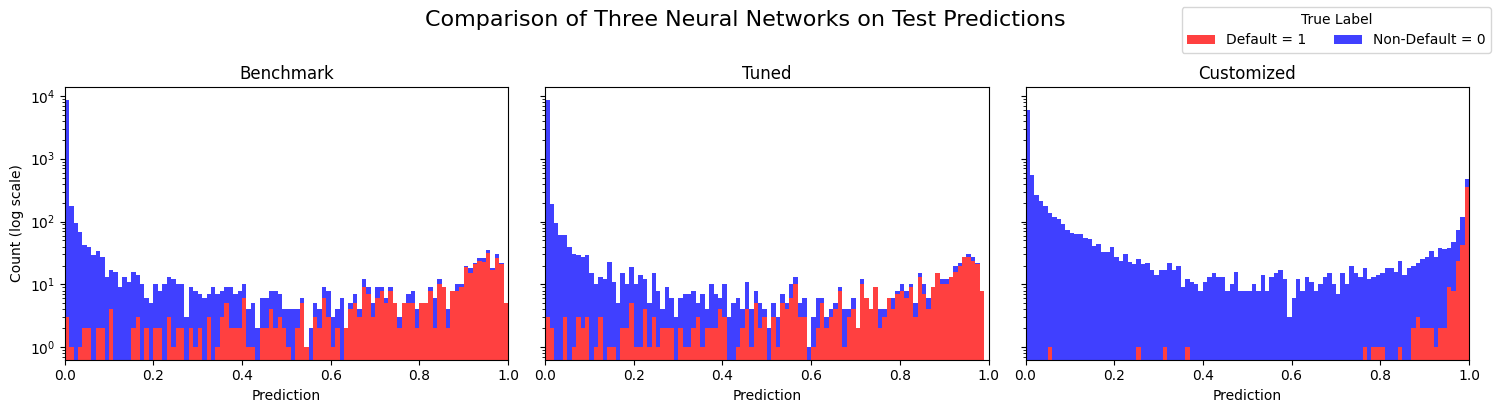

In [85]:
# Strategy Comparison:
pairs = [
    (NN_benchmark.flatten(), test_set_y2, 'Benchmark'),
    (NN_tuned.flatten(), test_set_y2, 'Tuned'),
    (NN_customized.flatten(), test_set_y2, 'Customized'),
]

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 4),
    sharey=True
)

for ax, (pred, real, title) in zip(axes, pairs):
    # split your preds by true label
    p0 = pred[real == 0]
    p1 = pred[real == 1]

    ax.hist(
        [p1, p0],
        bins=100,
        range=(0.0, 1.0),
        stacked=True,
        log=True,
        alpha=0.75,
        color = ['red', 'blue']
    )
    ax.set_xlim(0, 1)
    ax.set_xlabel('Prediction')
    ax.set_title(title)

# one common legend & y-label
axes[0].set_ylabel('Count (log scale)')
fig.legend(labels = ['Default = 1', 'Non-Default = 0'], loc='upper right', ncol=2, title='True Label')
plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.suptitle('Comparison of Three Neural Networks on Test Predictions', fontsize=16, y=1.02)
plt.show()

# Exercise 4. Comparison of lending strategies

In [86]:
# 4. Lending Strategy Simulation
interest_all = 0.055
interest_sel = 0.010

# Simulate 1000 market scenarios
np.random.seed(random_seed)
D = np.random.binomial(1,p2[m:, np.newaxis], size=(n, 1000))

# Strategies Profits (per borrower)
def strategy_per_borrower(d_matrix, selected_indices, interest):
    loan_amount = 100
    interest_payment = loan_amount * interest
    profit_matrix = np.zeros_like(d_matrix, dtype=float)
    profit_matrix[selected_indices] = np.where(
        d_matrix[selected_indices] == 0, interest_payment, -loan_amount
    )
    return profit_matrix.mean(axis=0)

# Strategies Total PnL
def strategy_total_profit(default_matrix, selected_indices, interest):
    loan_amount = 100
    # Calculate repayments and profit matrix
    repayments = loan_amount * (1 + interest)
    profit_matrix = np.where(default_matrix == 0, repayments, 0) - loan_amount
    return profit_matrix[selected_indices].sum(axis=0)

### Run Simulations

In [87]:
# Strategy (i): All borrowers
profit_i = strategy_per_borrower(D, np.arange(n), interest_all)
profit_i_mean = profit_i.mean(axis=0)

In [88]:
# Strategy (ii): Logistic Regression (threshold=0.05)
lr2_pred_test = logistic_regression_nonlinear.predict_proba(test_set_x)[:,1]
selected_lr = np.where(lr2_pred_test <= 0.05)[0]
profit_lr = strategy_per_borrower(D, selected_lr, interest_sel)
profit_lr_mean = profit_lr.mean(axis=0)

In [89]:
# Strategy (iii) -a : Neural Network (threshold=0.05)
nn1_pred_test = neural_network_nonlinear.predict(test_set_x).flatten()
selected_nn1 = np.where(nn1_pred_test <= 0.05)[0]
profit_nn1 = strategy_per_borrower(D, selected_nn1, interest_sel)
profit_nn1_mean = profit_nn1.mean(axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [90]:
# Strategy (iii) - b: Neural Network (threshold=0.05) tuned
nn2_pred_test = best_NN_nonlinear_cv.predict(test_set_x).flatten()
selected_nn2 = np.where(nn2_pred_test <= 0.05)[0]
profit_nn2 = strategy_per_borrower(D, selected_nn2, interest_sel)
profit_nn2_mean = profit_nn2.mean(axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [91]:
# Strategy (iii) - c: Neural Network (threshold=0.05) - customized
nn3_pred_test = neural_network_customized.predict(test_set_x).flatten()
selected_nn3= np.where(nn3_pred_test <= 0.05)[0]
profit_nn3 = strategy_per_borrower(D, selected_nn3, interest_sel)
profit_nn3_mean = profit_nn3.mean(axis=0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


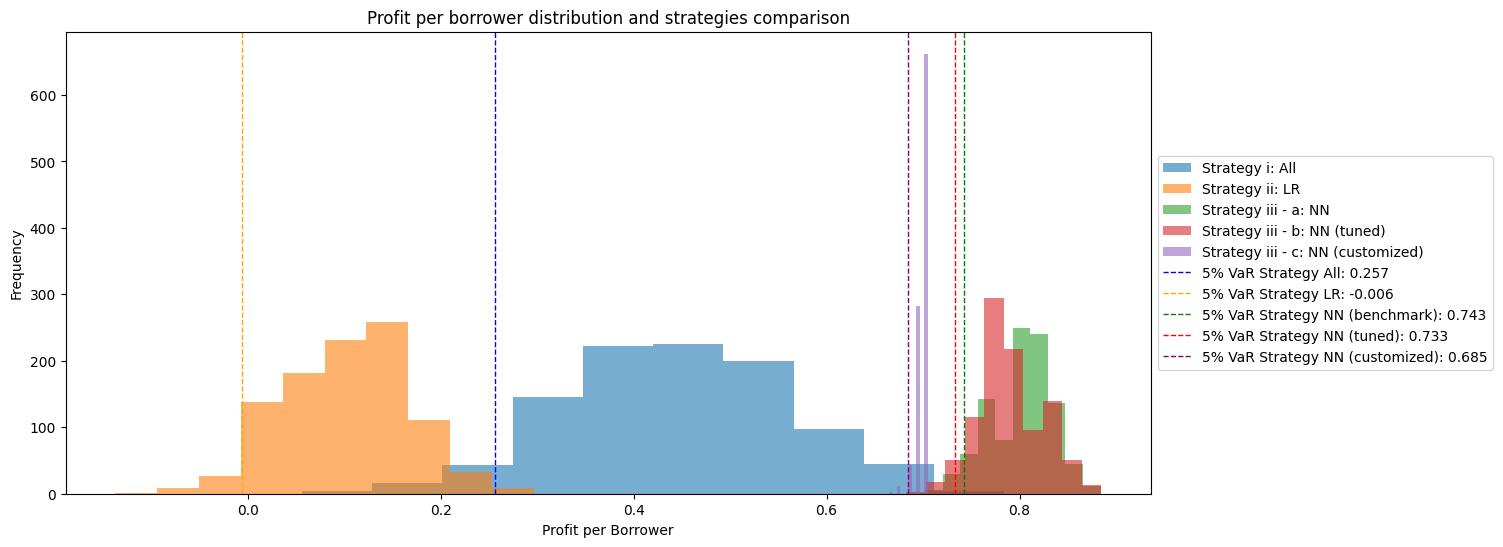

Mean Profit Strategy i: 0.443
Mean Profit Strategy LR: 0.103
Mean Profit Strategy NN: 0.801
Mean Profit Strategy NN (tuned): 0.790
Mean Profit Strategy NN (customized): 0.701
5% VaR Strategy All: 0.257
5% VaR Strategy LR: -0.006
5% VaR Strategy NN (benchmark): 0.743
5% VaR Strategy NN (tuned): 0.733
5% VaR Strategy NN (customized): 0.685


In [92]:
# Visualize Results

plt.figure(figsize=(14, 6))
# Plot histograms of the five strategies
plt.hist(profit_i, bins=10, alpha=0.6, label='Strategy i: All')
plt.hist(profit_lr, bins=10, alpha=0.6, label='Strategy ii: LR')
plt.hist(profit_nn1, bins=10, alpha=0.6, label='Strategy iii - a: NN')
plt.hist(profit_nn2, bins=10, alpha=0.6, label='Strategy iii - b: NN (tuned)')
plt.hist(profit_nn3, bins=10, alpha=0.6, label='Strategy iii - c: NN (customized)')

plt.xlabel('Profit per Borrower')
plt.axvline(np.percentile(profit_i, 5), color='blue', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy All: {np.percentile(profit_i, 5):.3f}')
plt.axvline(np.percentile(profit_lr, 5), color='orange', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
plt.axvline(np.percentile(profit_nn1, 5), color='green', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (benchmark): {np.percentile(profit_nn1, 5):.3f}')
plt.axvline(np.percentile(profit_nn2, 5), color='red', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (tuned): {np.percentile(profit_nn2, 5):.3f}')
plt.axvline(np.percentile(profit_nn3, 5), color='purple', linestyle='dashed', linewidth=1, label=f'5% VaR Strategy NN (customized): {np.percentile(profit_nn3, 5):.3f}')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.title('Profit per borrower distribution and strategies comparison')
plt.show()

#print the mean profit for each strategy
print(f'Mean Profit Strategy i: {profit_i_mean:.3f}')
print(f'Mean Profit Strategy LR: {profit_lr_mean:.3f}')
print(f'Mean Profit Strategy NN: {profit_nn1_mean:.3f}')
print(f'Mean Profit Strategy NN (tuned): {profit_nn2_mean:.3f}')
print(f'Mean Profit Strategy NN (customized): {profit_nn3_mean:.3f}')

# Calculate VaR per borrower for the three strategies
print(f'5% VaR Strategy All: {np.percentile(profit_i, 5):.3f}')
print(f'5% VaR Strategy LR: {np.percentile(profit_lr, 5):.3f}')
print(f'5% VaR Strategy NN (benchmark): {np.percentile(profit_nn1, 5):.3f}')
print(f'5% VaR Strategy NN (tuned): {np.percentile(profit_nn2, 5):.3f}')
print(f'5% VaR Strategy NN (customized): {np.percentile(profit_nn3, 5):.3f}')

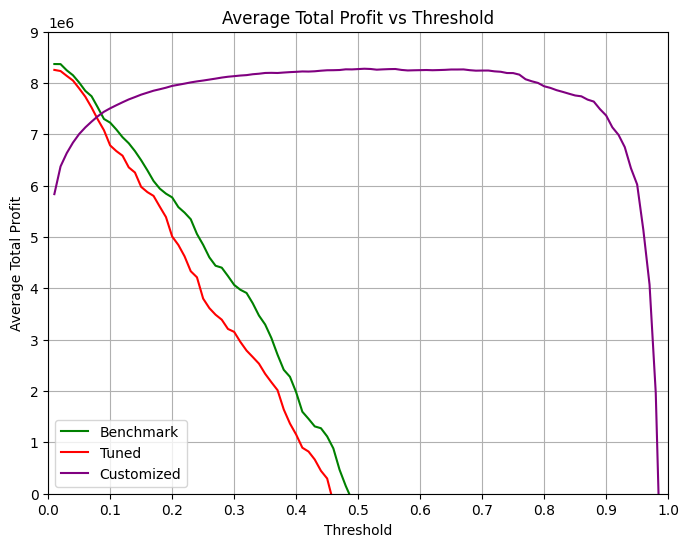

In [93]:
# Optimal threshold selection maximizing total PnL

def strategy_thresholds(D, thresholds, nn):
  best_threshold, best_total_profit = 0, 0
  total_profits_vs_threshold = []

  for thresh in thresholds:
      selected_nn_thresh = np.where(nn <= thresh)[0]
      total_profit = strategy_total_profit(D, selected_nn_thresh, interest_sel).sum()
      total_profits_vs_threshold.append(total_profit)
      if total_profit > best_total_profit:
          best_total_profit = total_profit
          best_threshold = thresh

  return best_threshold, best_total_profit, total_profits_vs_threshold

thresholds = np.linspace(0.01, 0.99, 99)
nn1_threshold, nn1_total_profit, nn1_profit_vs_threshold = strategy_thresholds(D, thresholds, nn1_pred_test)
nn2_threshold, nn2_total_profit, nn2_profit_vs_threshold = strategy_thresholds(D, thresholds, nn2_pred_test)
nn3_threshold, nn3_total_profit, nn3_profit_vs_threshold = strategy_thresholds(D, thresholds, nn3_pred_test)

# Plot Total Profit vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, nn1_profit_vs_threshold, color='green', label='Benchmark')
plt.plot(thresholds, nn2_profit_vs_threshold, color='red', label='Tuned')
plt.plot(thresholds, nn3_profit_vs_threshold, color='purple', label='Customized')
plt.ylim(0, 9000000)
plt.xlim(0, 1.0)  # Start at 0, end at 1.0
plt.xticks(np.arange(0, 1.1, 0.1))  # Ticks every 0.1 from 0 to 1.0
plt.xlabel('Threshold')
plt.ylabel('Average Total Profit')
plt.title('Average Total Profit vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

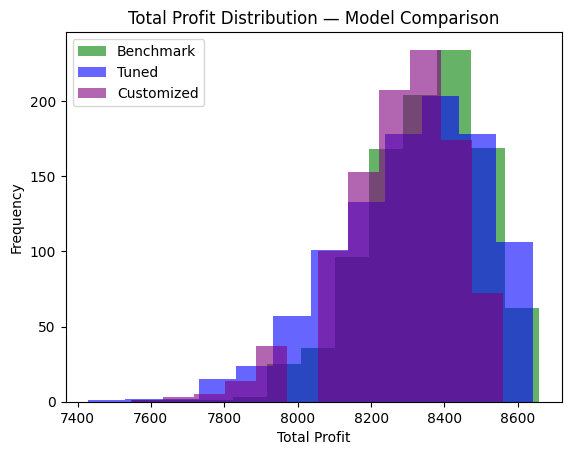

In [94]:
# Final optimal NN strategy based on total PnL
nn1_pred_total = np.where(nn1_pred_test <= nn1_threshold)[0]
nn1_profit_total = strategy_total_profit(D, nn1_pred_total, interest_sel)

nn2_pred_total = np.where(nn2_pred_test <= nn2_threshold)[0]
nn2_profit_total = strategy_total_profit(D, nn2_pred_total, interest_sel)

nn3_pred_total = np.where(nn3_pred_test <= nn3_threshold)[0]
nn3_profit_total = strategy_total_profit(D, nn3_pred_total, interest_sel)

# Plot histogram for optimized strategy (total profit)
plt.hist(nn1_profit_total, bins=12, alpha=0.6, label='Benchmark', color='green')
plt.hist(nn2_profit_total, bins=12, alpha=0.6, label='Tuned', color='blue')
plt.hist(nn3_profit_total, bins=12, alpha=0.6, label='Customized', color='purple')
plt.xlabel('Total Profit')
plt.ylabel('Frequency')
plt.legend()
plt.title('Total Profit Distribution — Model Comparison')
plt.show()

In [95]:
# Print Simulation Statistics

profits = {
    "Benchmark": (nn1_profit_total, nn1_threshold),
    "Tuned": (nn2_profit_total, nn2_threshold),
    "Customized": (nn3_profit_total, nn3_threshold),
}

# Header
print(f"{'Model':<15} {'5% VaR':>10} {'Avg PnL':>10} {'Std Dev':>10} {'Thresh':>10}")
print("-" * 60)

# Rows
# Print each row
for name, (pnl, thr) in profits.items():
    var5  = np.percentile(pnl, 5)
    mean  = pnl.mean()
    std   = pnl.std()
    print(f"{name:<15} {var5:10.0f} {mean:10.0f} {std:10.0f} {thr:10.2f}")

Model               5% VaR    Avg PnL    Std Dev     Thresh
------------------------------------------------------------
Benchmark             8052       8371        173       0.01
Tuned                 7934       8256        203       0.01
Customized            7953       8279        173       0.51
